# Tracking a moving stystem with outliers

In [1]:
import jax
import pickle
import datagen
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from functools import partial
from rebayes_mini import callbacks
from bayes_opt import BayesianOptimization
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "KF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "KF": "lightseagreen",
    "WLF-MD": "gold",
    "KF-B": "darkorange",
}

## Multiple samples

In [3]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0

In [4]:
name_dgen = "mean"
name_dgen = "covariance"

match name_dgen:
    case "covariance":
        dgen = datagen.GaussStMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            dof_observed=2.01
        )
    case "mean":
        dgen = datagen.GaussMeanOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_scale=2.0,
        )
    case "added_mean":
        dgen = datagen.GaussOneSideOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_minval=-100,
            outlier_maxval=100
        )
    case _:
        raise ValueError(f"Dgen {name_dgen} not valid")

In [5]:
key = jax.random.PRNGKey(314)
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 1000
n_samples = 500
keys = jax.random.split(key, n_samples)

colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)

yv = datasets["observed"]
statev = datasets["latent"]

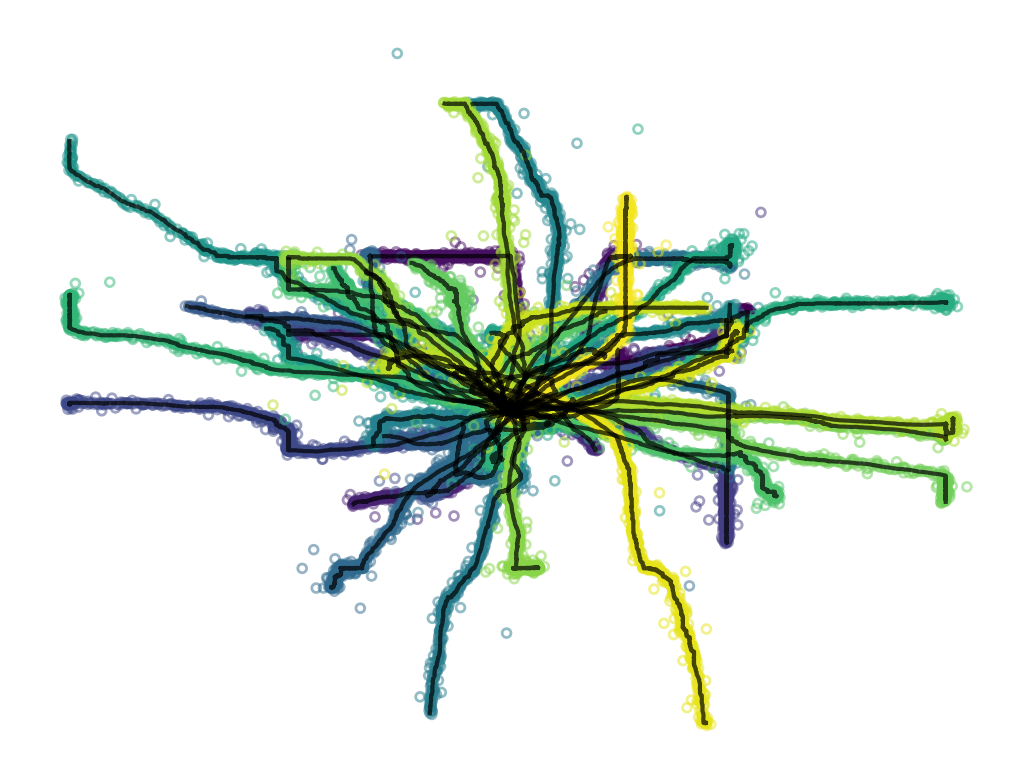

In [6]:
datasets_cpu = jax.tree_map(lambda x: np.array(x[::10]), datasets)
for i, color in enumerate(colors[::10]):
    dataset = jax.tree_map(lambda x: x[i], datasets_cpu)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    
plt.axis("off");

In [7]:
def latent_fn(z):
    return dgen.transition_matrix @ z

def measurement_fn(z, _):
    return dgen.projection_matrix @ z

## Metrics

In [8]:
time_methods = {}
hist_methods = {}
configs = {}

## Kalman Filter

In [9]:
@jax.jit
def filter_kf(measurements, state):
    nsteps = len(measurements)
    agent_imq = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=1e8,
    )
    
    init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

In [10]:
method = "KF"

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kf(y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.49it/s]


## KF-IW

In [11]:
@jax.jit
def filter_kfiw(noise_scaling, n_inner, measurements, state):
    n_inner = n_inner.astype(int)
    agent_rkf = rkf.KalmanFilterInverseWishart(
        dgen.transition_matrix,
        dgen.dynamics_covariance,
        dgen.observation_covariance,
        n_inner=n_inner,
        noise_scaling=noise_scaling
    )
    
    
    init_bel = agent_rkf.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent_rkf.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, dgen.projection_matrix)
    
    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfiw(noise_scaling, n_inner):
    err, _ = filter_kfiw(noise_scaling, n_inner, yv[0], statev[0])
    err = err.max()
    err = jax.lax.cond(jnp.isnan(err), lambda: 1e6, lambda: err)
    return -err

In [12]:
bo = BayesianOptimization(
    bo_filter_kfiw,
    pbounds={
        "noise_scaling": (1e-6, 20),
        "n_inner":  (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |  n_inner  | noise_... |
-------------------------------------------------
| 4         | -166.6    | 7.552     | 5.21      |
| 15        | -164.5    | 1.952     | 1.208     |


In [13]:
method = "KF-IW"
noise_scaling = bo.max["params"]["noise_scaling"]
n_inner = int(bo.max["params"]["n_inner"])

configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kfiw(noise_scaling, n_inner, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 44.66it/s]


## WLF-IMQ

In [14]:
@jax.jit
def filter_wlfimq(soft_threshold, measurements, state):
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfimq(soft_threshold):
    err, _ = filter_wlfimq(soft_threshold, yv[0], statev[0])
    return -err.max()

In [15]:
bo = BayesianOptimization(
    bo_filter_wlfimq,
    pbounds={
        "soft_threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1,
    allow_duplicate_points=True
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | soft_t... |
-------------------------------------
| 2         | -166.2    | 11.77     |
| 3         | -164.2    | 5.301     |
| 8         | -164.0    | 5.21      |
| 29        | -163.0    | 4.341     |
| 39        | -162.7    | 3.997     |


In [16]:
method = "WLF-IMQ"
soft_threshold = bo.max["params"]["soft_threshold"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfimq(soft_threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.53it/s]


## WLF-MD

In [17]:
@jax.jit
def filter_wlfmd(threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfmd(threshold):
    err, _ = filter_wlfmd(threshold, yv[0], statev[0])
    return -err.max()

In [18]:
bo = BayesianOptimization(
    bo_filter_wlfmd,
    pbounds={
        "threshold": (1e-6, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   | threshold |
-------------------------------------
| 2         | -167.7    | 11.77     |
| 3         | -167.6    | 5.301     |
| 8         | -167.5    | 5.21      |
| 14        | -167.2    | 7.72      |
| 23        | -167.1    | 3.663     |
| 24        | -166.9    | 6.79      |
| 31        | -166.6    | 6.254     |
| 48        | -166.6    | 5.939     |


In [19]:
method = "WLF-MD"
threshold = bo.max["params"]["threshold"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfmd(threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 50.09it/s]


## KF-B

In [20]:
@jax.jit
def filter_kfb(alpha, beta, n_inner, measurements, state):
    """
    Outlier ekf
    """
    n_inner = n_inner.astype(int)
    agent = rkf.ExtendedKalmanFilterBernoulli(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        alpha=alpha,
        beta=beta,
        tol_inlier=1e-7,
        n_inner=n_inner,
    )

    init_bel = agent.init_bel(initial_mean, cov=1.0)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_kfb(alpha, beta, n_inner):
    err, _ = filter_kfb(alpha, beta, n_inner, yv[0], statev[0])
    err = -err.max()
    err = jax.lax.cond(jnp.isnan(err), lambda: -1e6, lambda: err)
    return err

In [21]:
bo = BayesianOptimization(
    bo_filter_kfb,
    pbounds={
        "alpha": (0.0, 5.0),
        "beta": (0.0, 5.0),
        "n_inner": (1, 10),
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=30)

|   iter    |  target   |   alpha   |   beta    |  n_inner  |
-------------------------------------------------------------
| 10        | -169.8    | 4.174     | 0.5288    | 1.544     |


In [22]:
method = "KF-B"
alpha = bo.max["params"]["alpha"]
beta = bo.max["params"]["beta"]
n_inner = bo.max["params"]["n_inner"]
configs[method] = bo.max["params"]

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kfb(alpha, beta, n_inner, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = times

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 26.68it/s]


## Store data

## Plot comparison

In [25]:
err_methods = jax.tree_map(lambda x: x - statev, hist_methods)

In [26]:
diff_df = jax.tree_map(lambda x: np.sum(x ** 2, axis=1), err_methods)

diff_df = pd.concat([
    pd.DataFrame(diff_df[k]).reset_index().melt("index").assign(method=k)
    for k in diff_df
])
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error",
        "index": "trial"
    },
    axis=1
)

# diff_df["state"] = diff_df["state"].apply(lambda x: rf"$\theta_{x}$")

/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gerardoduran/miniconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and wil

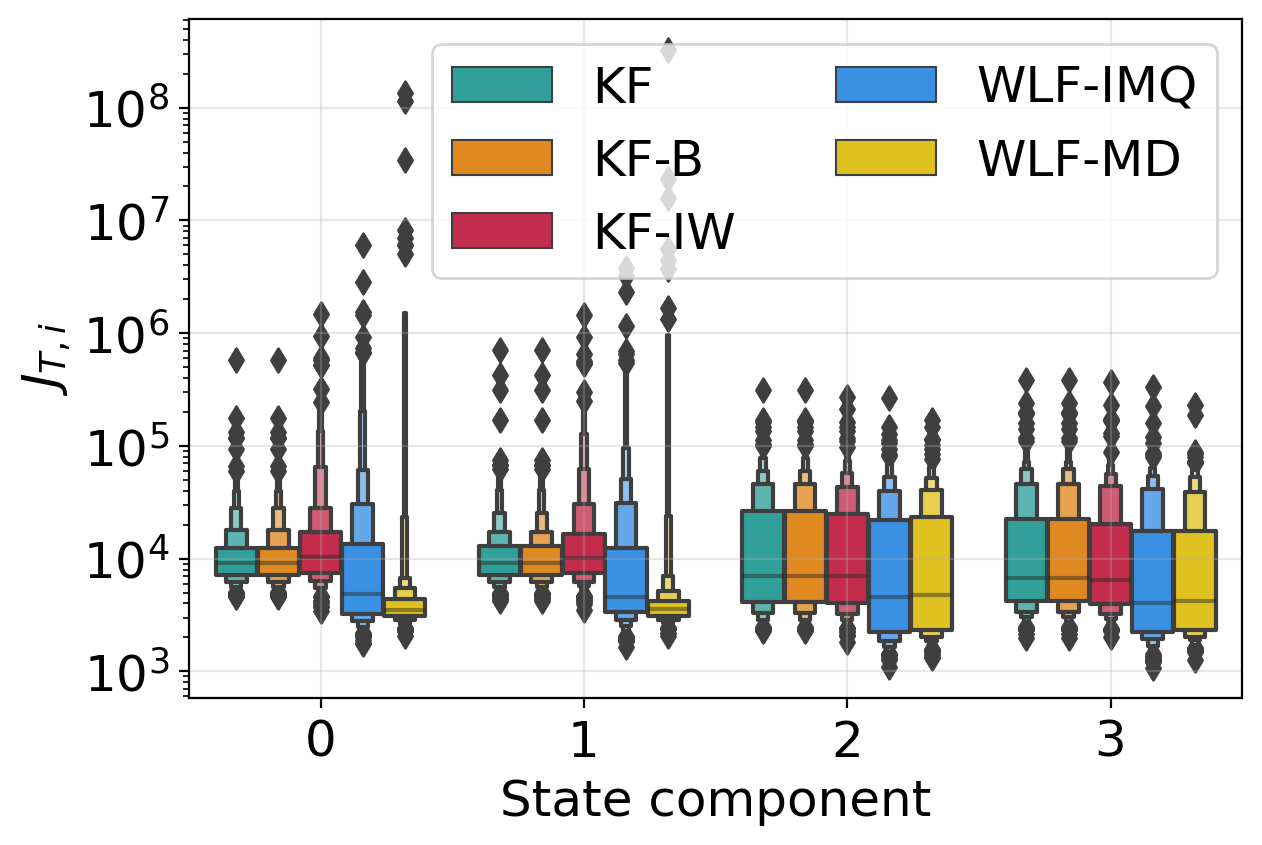

In [27]:
methods = sorted(diff_df.method.unique())
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df,
    palette=cmap,
    hue_order=methods,
)
plt.legend(ncol=2)
plt.xlabel("State component")
plt.ylabel("$J_{T,i}$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.yscale("log")

In [28]:
# remove first iteration (used to compile functions)
time_df = pd.DataFrame(time_methods).iloc[1:]

In [29]:
(time_df.mean(axis=0) / time_df["KF"].mean(axis=0) - 1)

KF         0.000000
KF-IW      0.200989
WLF-IMQ    0.000380
WLF-MD     0.066567
KF-B       1.001216
dtype: float64

In [30]:
summary = pd.merge(
    diff_df,
    time_df.reset_index().melt("index").rename({"index": "trial", "variable": "method"}, axis=1),
    on=["method", "trial"],
    how="inner"
)
summary.head()

,trial,state,error,method,value
0,1,0,12317.342773,KF,0.000110
1,1,1,10653.384766,KF,0.000110
2,1,2,8716.882812,KF,0.000110
3,1,3,3887.811523,KF,0.000110
4,2,0,7405.613281,KF,0.000151


In [31]:
(time_df / time_df["KF"].mean()).describe().loc["mean"].round(1).sort_index()

KF         1.0
KF-B       2.0
KF-IW      1.2
WLF-IMQ    1.0
WLF-MD     1.1
Name: mean, dtype: float64

## Single model comparison

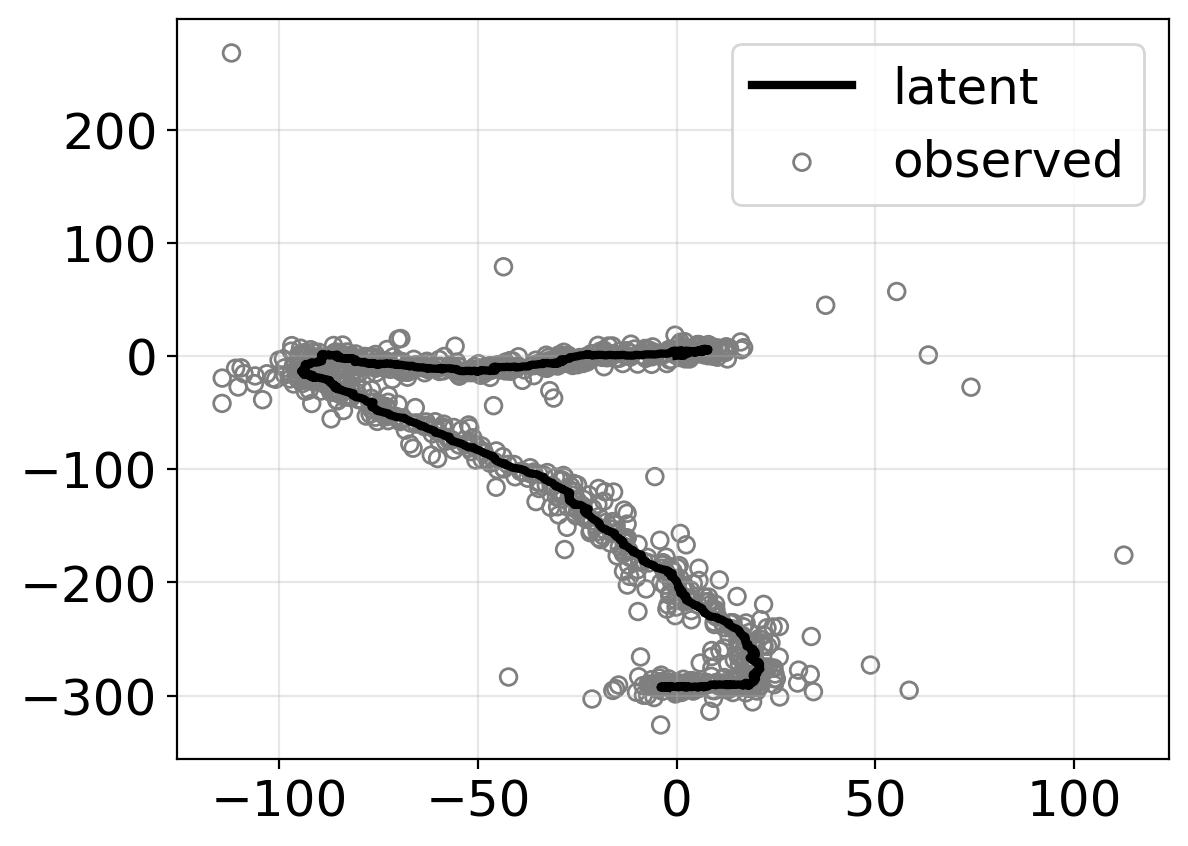

In [67]:
i = 1
i = 4

hist_runs = jax.tree_map(lambda x: x[i, :, :2], hist_methods)
latent_i = datasets["latent"][i, :, :2].T
observed_i = yv[i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)

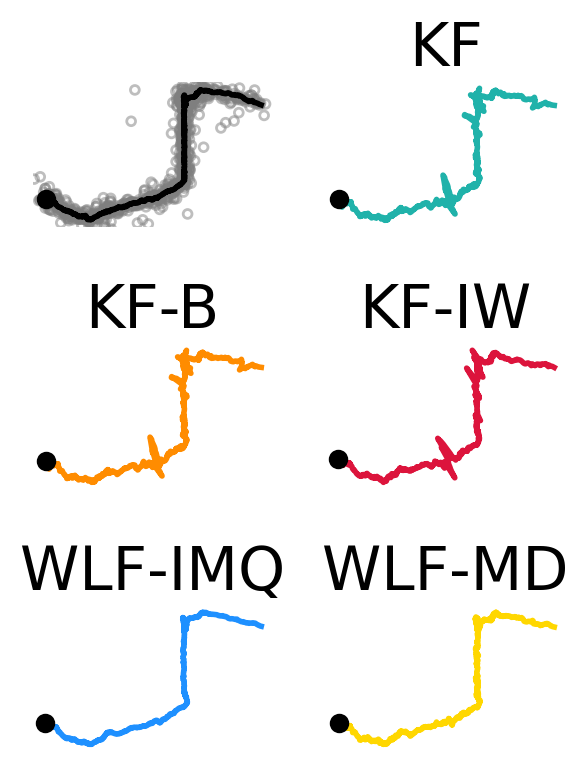

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(6.4 * 0.5, 4.2))

for ax, key in zip(axs.ravel()[1:], hist_runs):
    state_est = hist_runs[key]
    ax.plot(*state_est.T, c=cmap[key], linewidth=2)
    ax.set_title(key)
    ax.axis("off")
    ax.scatter(0,0, c="black", zorder=3)
    
ylim = ax.get_ylim()
xlim = ax.get_xlim()

axs[0, 0].scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed", alpha=0.5, s=10)
axs[0, 0].plot(*latent_i, c="black", label="latent", linewidth=2.0)
axs[0, 0].axis("off")
axs[0, 0].scatter(0, 0, c="black", zorder=3)
axs[0, 0].set_ylim(*ylim)
axs[0, 0].set_xlim(*xlim)


plt.tight_layout()
# plt.savefig(f"./figures/2d-ssm-comparison-single-run-{name_dgen}.png", dpi=300)

## Weight plots

In [78]:
@jax.jit
def filter_wlfimq_pred(soft_threshold, measurements, state):
    nsteps = len(measurements)
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=soft_threshold,
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent.scan, callback_fn=callbacks.get_predicted_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def filter_wlfmd_pred(threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold,
    )
    
    init_bel = agent.init_bel(initial_mean, cov=1.0)
    filterfn = partial(agent.scan, callback_fn=callbacks.get_predicted_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

In [74]:
soft_threshold = configs["WLF-IMQ"]["soft_threshold"]
threshold = configs["WLF-MD"]["threshold"]

In [148]:
ix = 1
y = yv[ix]
state = statev[ix]

steps = np.arange(n_steps)

In [143]:
outliers = np.array(datasets["is_outlier"][ix])

## WLF-IMQ

In [233]:
vmin, vmax = 150, 300
vmin, vmax = 200, 400

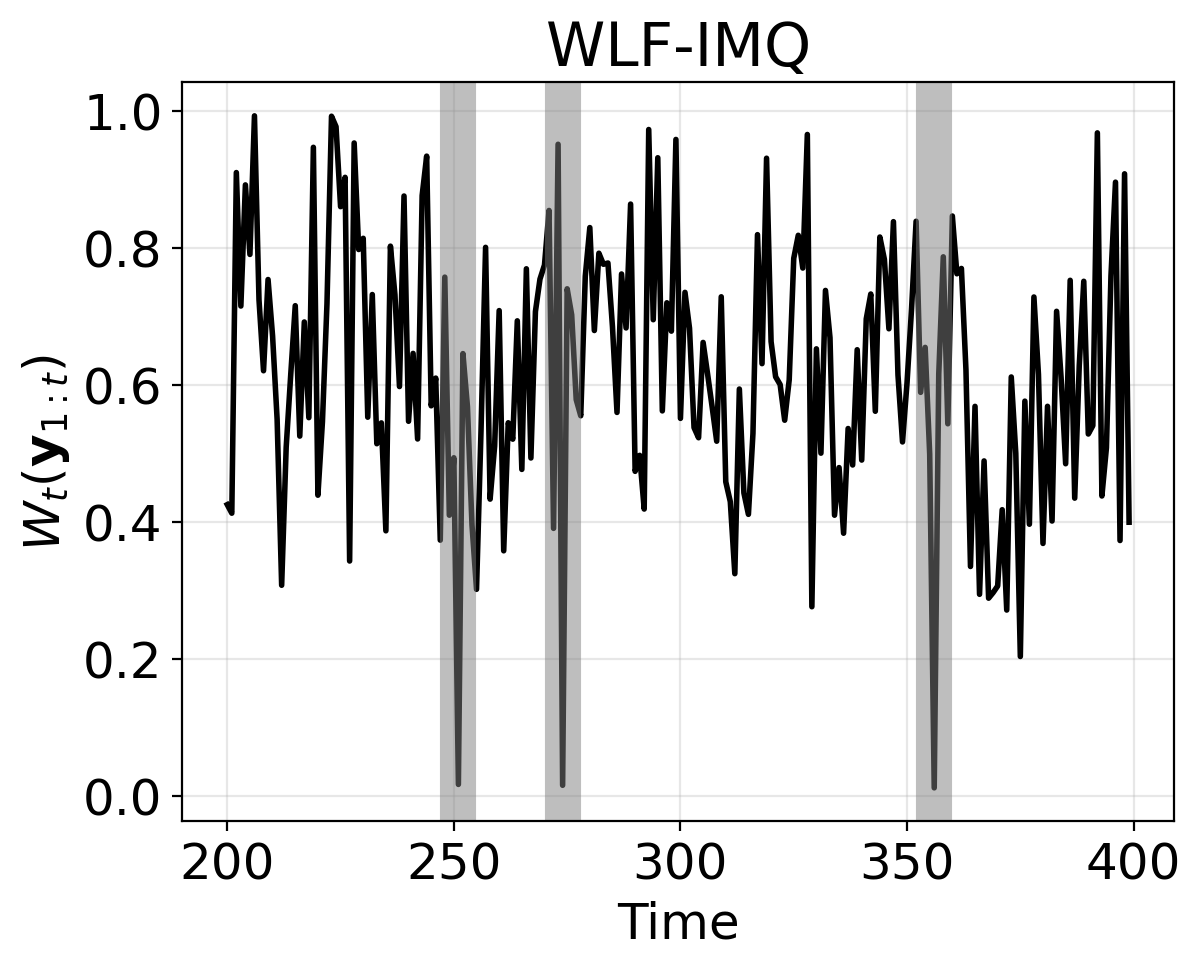

In [234]:
_, run = filter_wlfimq_pred(soft_threshold, y, state)

err = (y - run[:, :2])
weighting_term_imq = np.sqrt(soft_threshold  ** 2 / (soft_threshold ** 2 + jnp.power(err, 2).sum(axis=1)))

trange = slice(vmin, vmax)
plt.plot(steps[trange], weighting_term_imq[trange], c="black", linewidth=2)
for ot in np.argwhere(outliers).ravel():
    if vmin <= ot < vmax:
        plt.axvline(ot, color="tab:gray", linewidth=13, alpha=0.5)
plt.grid(alpha=0.3)
plt.xlabel("Time")
plt.ylabel(r"$W_t({\bf y}_{1:t})$")
plt.title("WLF-IMQ")
plt.savefig("./figures/2d-ssm-weight-history-wlf-imq.png", dpi=300)

In [235]:
1 - (outliers == ~weighting_term_md)[np.where(outliers)].mean()

0.07407407407407407

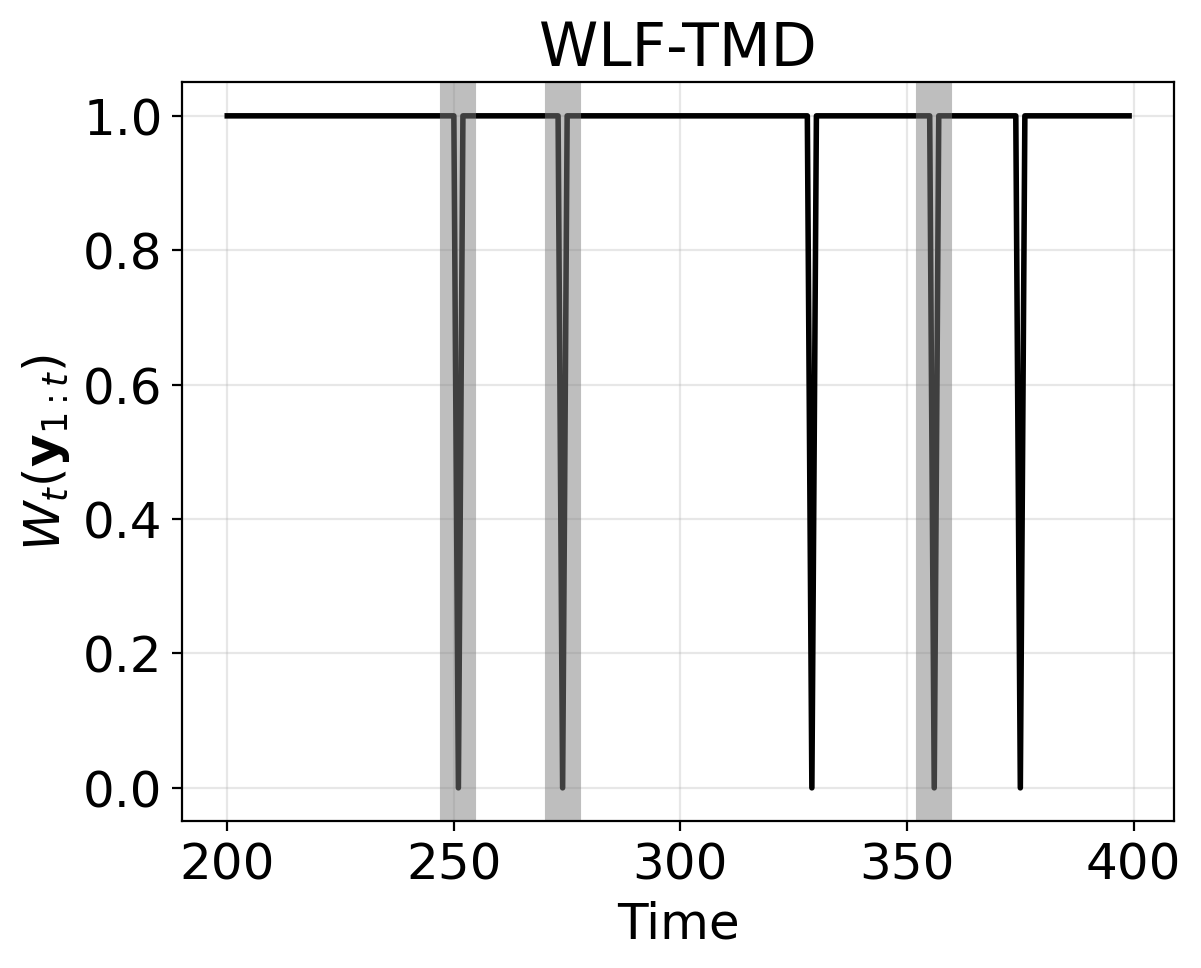

In [237]:
_, run = filter_wlfmd_pred(soft_threshold, y, state)
err = (y - run[:, :2])
prec = np.linalg.inv(dgen.observation_covariance)
weighting_term_md = np.sqrt(np.einsum("sj,jk,sk->s", err, prec, err)) < soft_threshold

trange = slice(vmin, vmax)
plt.plot(steps[trange], weighting_term_md[trange], c="black", linewidth=2)
for ot in np.argwhere(outliers).ravel():
    if vmin <= ot < vmax:
        plt.axvline(ot, color="tab:gray", linewidth=13, alpha=0.5)
plt.grid(alpha=0.3)
plt.xlabel("Time")
plt.ylabel(r"$W_t({\bf y}_{1:t})$")
plt.title("WLF-TMD")
plt.savefig("./figures/2d-ssm-weight-history-wlf-tmd.png", dpi=300)

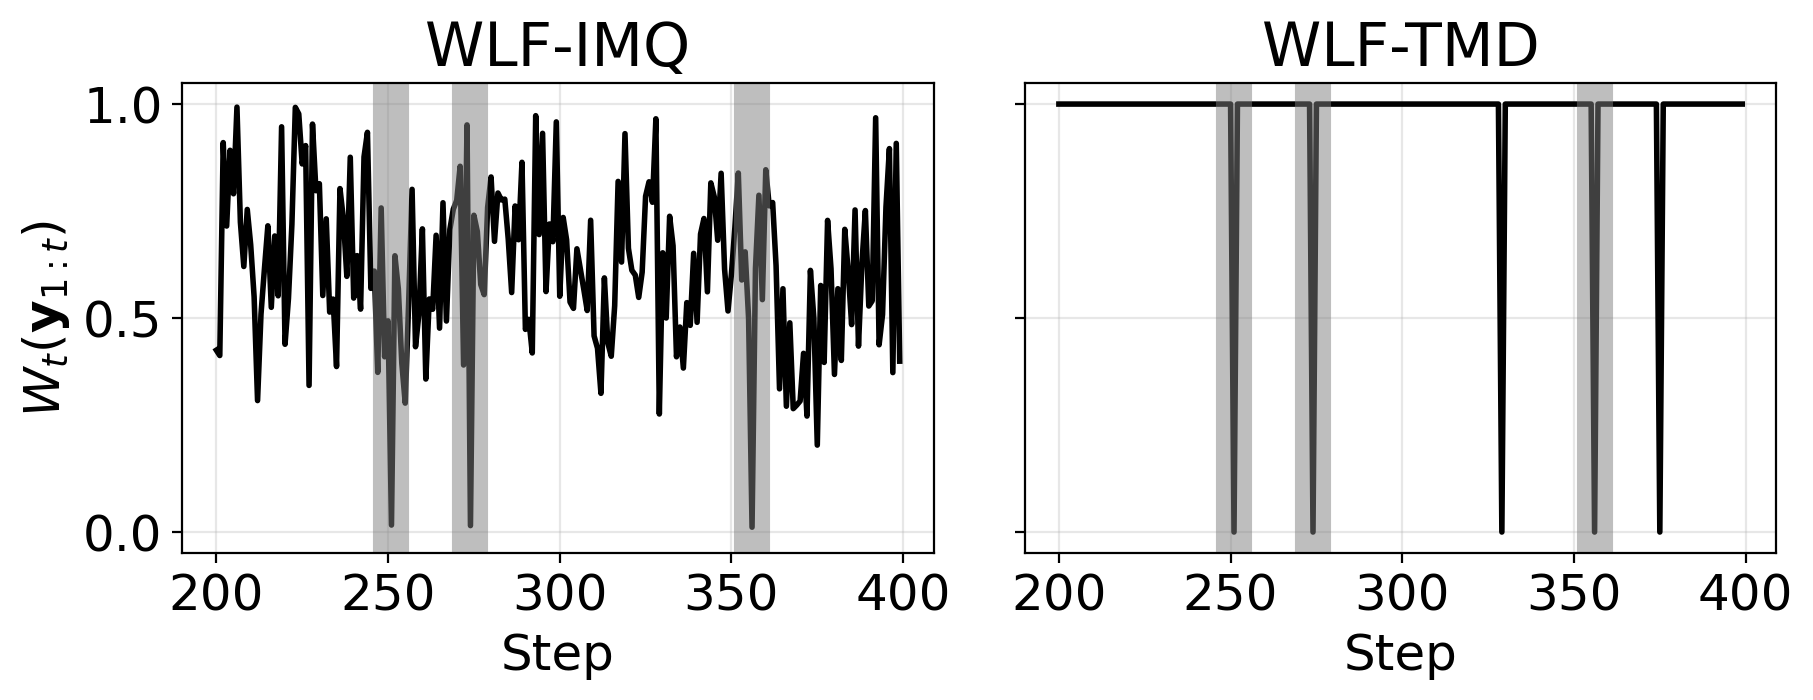

In [238]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6.4 * 1.5, 4.8 * 0.8))

ax[0].plot(steps[trange], weighting_term_imq[trange], c="black", linewidth=2)
ax[1].plot(steps[trange], weighting_term_md[trange], c="black", linewidth=2)

ax[0].set_title("WLF-IMQ")
ax[1].set_title("WLF-TMD")

for axi in ax:
    axi.grid(alpha=0.3)
    axi.set_xlabel("Step")
    for ot in np.argwhere(outliers).ravel():
        if vmin <= ot < vmax:
            axi.axvline(ot, color="tab:gray", linewidth=13, alpha=0.5)
            
ax[0].set_ylabel(r"$W_t({\bf y}_{1:t})$")
plt.tight_layout()
plt.savefig("./figures/2d-ssm-weight-history-wlf-both.png", dpi=300)

## An animation

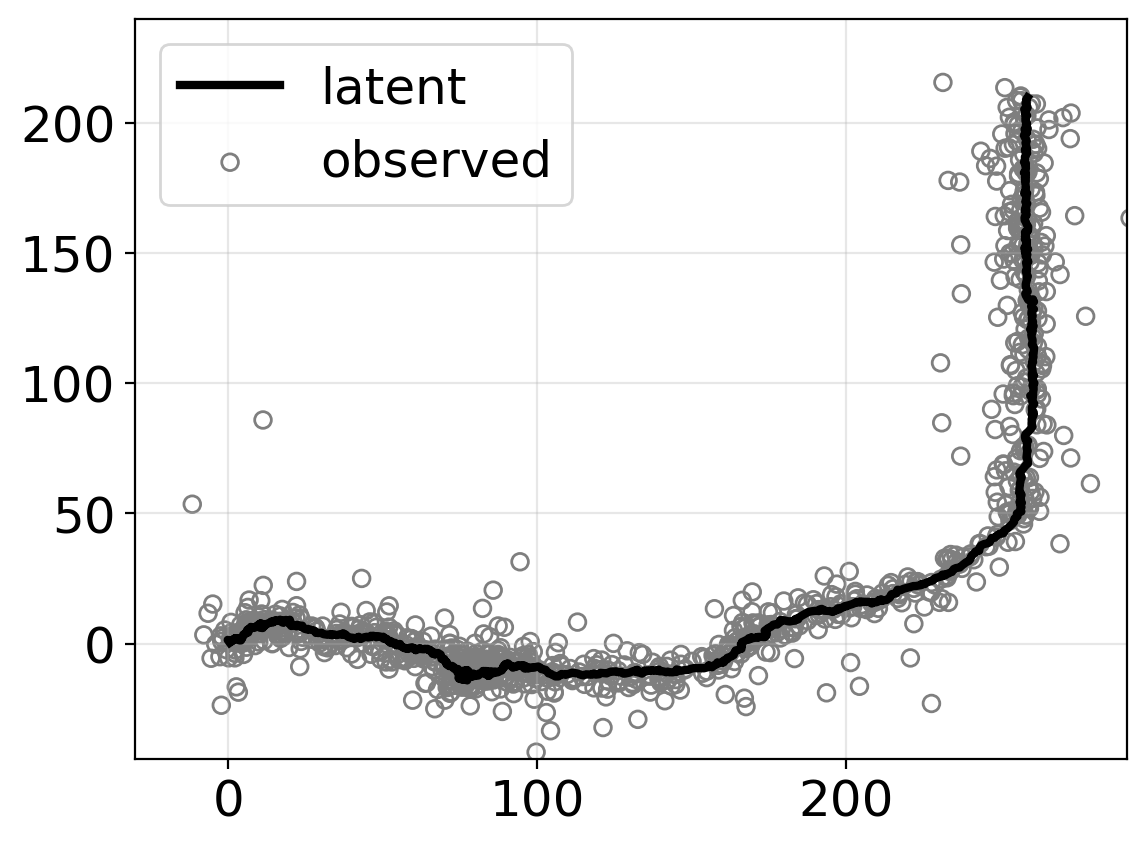

In [244]:
i = 10
# i = 12

hist_runs = jax.tree_map(lambda x: x[i, :, :2], hist_methods)

latent_i = np.array(datasets["latent"][i, :, :2].T)
observed_i = np.array(yv[i].T)
hist_run = np.array(hist_runs["KF"].T)

xmin, ymin = latent_i.min(axis=1) - 30
xmax, ymax = latent_i.max(axis=1) + 30

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

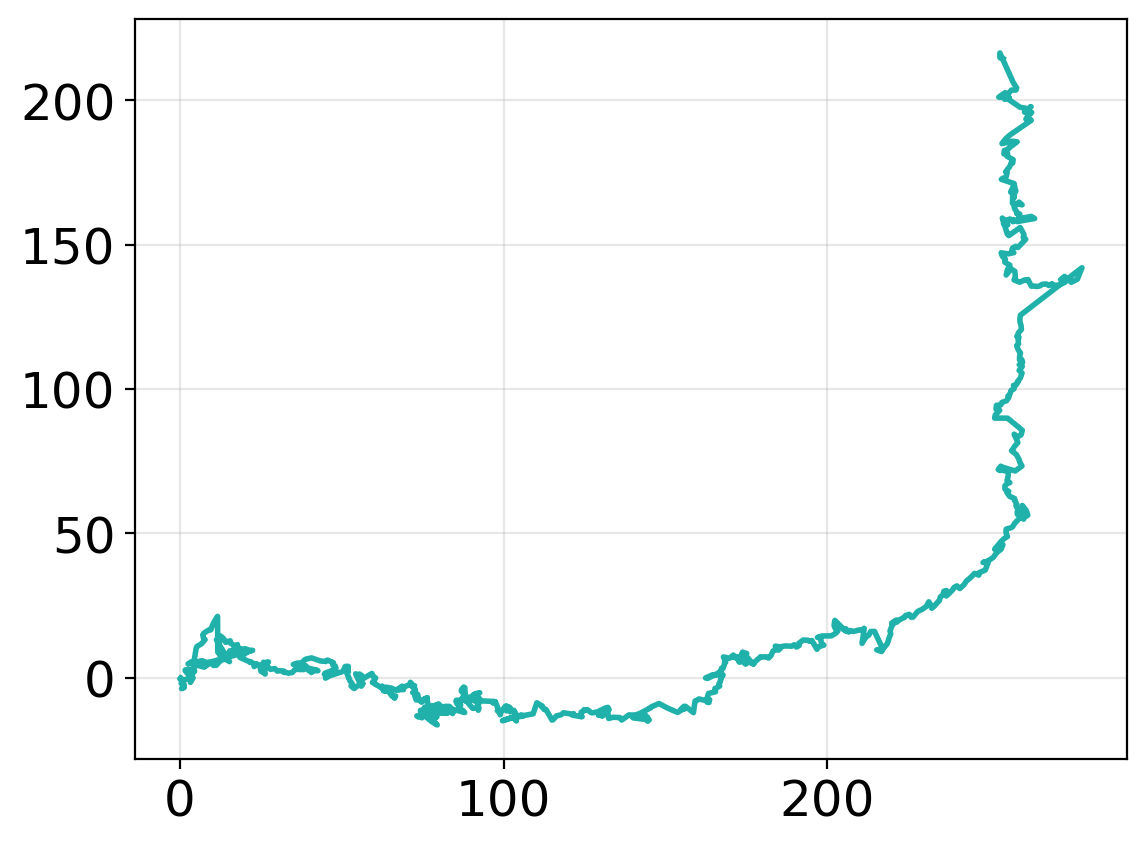

In [245]:
# plt.plot(*hist_runs["KF"].T, linewidth=2, c="black")
method = "WLF-IMQ"
method = "KF"
plt.plot(*hist_runs[method].T, linewidth=2, c=cmap[method])
plt.grid(alpha=0.3)

In [184]:
from matplotlib.animation import FuncAnimation

MovieWriter ffmpeg unavailable; using Pillow instead.


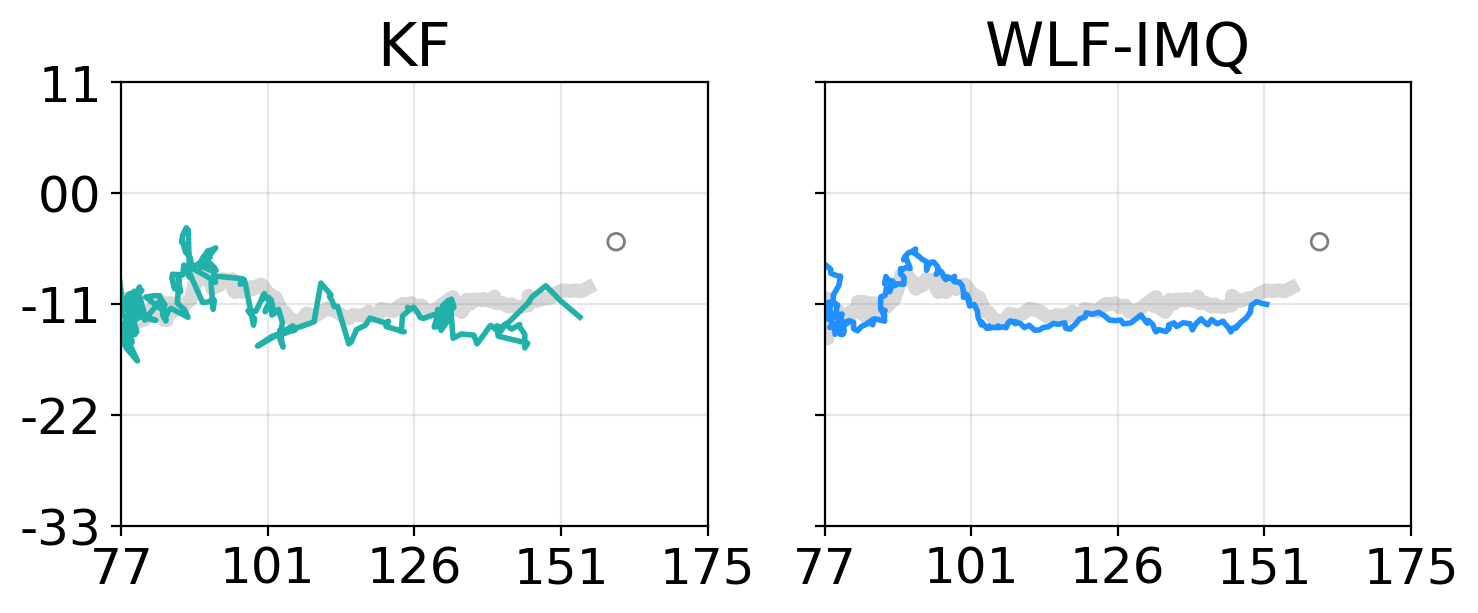

In [276]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6.4 * 1.3, 4.8 * 0.6))

method = "KF"
methods = ["KF", "WLF-IMQ"]
def animate(t):
    print(f"@ Frame {t}", end="\r")
    ax[0].cla()
    ax[1].cla()

    tmin = max(t - 100, 0)
    xobs, yobs = observed_i[:, t]
    # ax[0].plot(*latent_i[:, :t], c="black", label="latent", linewidth=3)
    for axi, method in zip(ax, methods):
        filtered_state = hist_runs[method][:t]
        latent_sub = latent_i[:, :t]
        
        axi.cla()
        axi.scatter(xobs, yobs, c="none", edgecolor="tab:gray", label="observed")
        # axi.axhline(yobs, c="gray", alpha=0.3, lw=5)
        # axi.axvline(xobs, c="gray", alpha=0.3, lw=5)
        axi.plot(*latent_sub, c="gray", label="latent", linewidth=5, alpha=0.3)
    
        axi.plot(*filtered_state.T, linewidth=2, c=cmap[method])

        if len(filtered_state) > 0:
            xmax, ymax = latent_sub[:, tmin:].max(axis=1) + 20
            xmin, ymin = latent_sub[:, tmin:].min(axis=1) - 20
            axi.set_xlim(xmin, xmax)
            axi.set_ylim(ymin, ymax)
    
            xticks = np.linspace(xmin, xmax, 5)
            yticks = np.linspace(ymin, ymax, 5)
            xticklabels = [format(x, "02.0f") for x in xticks]
            yticklabels = [format(y, "02.0f") for y in yticks]
            axi.set(
                xticks=xticks,
                yticks=yticks,
                xticklabels=xticklabels,
                yticklabels=yticklabels,
            )
        
        
        axi.grid(alpha=0.3)
        axi.set_title(method)


frames = np.arange(550, n_steps)
animation = FuncAnimation(fig, animate, frames=frames)
animation.save(f"./figures/2d-tracking.gif", fps=20)

MovieWriter ffmpeg unavailable; using Pillow instead.


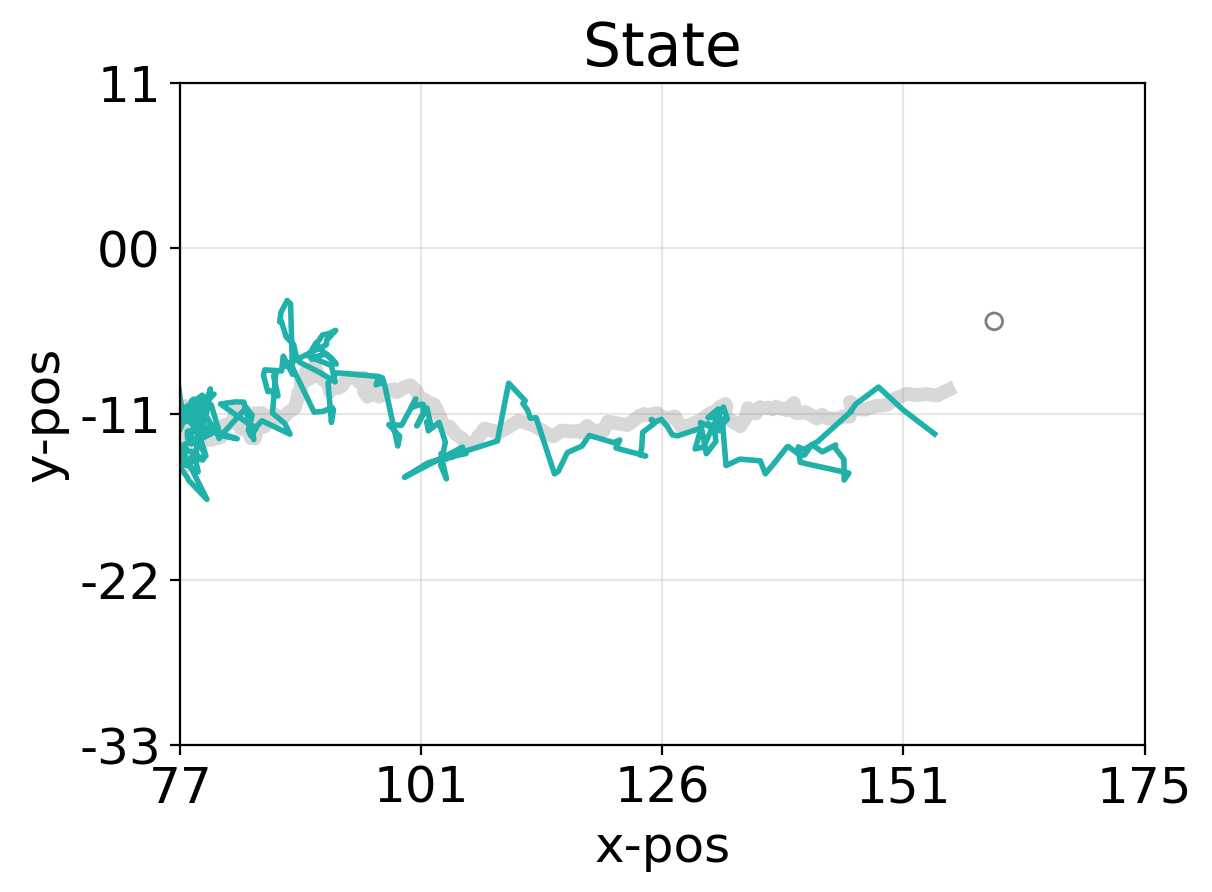

In [268]:
fig, ax = plt.subplots(sharey=True, figsize=(6.4, 4.8))

method = "KF"
def animate(t):
    print(f"@ Frame {t}", end="\r")
    ax.cla()

    filtered_state = hist_runs[method][:t]
    latent_sub = latent_i[:, :t]
    
    tmin = max(t - 100, 0)
    xobs, yobs = observed_i[:, t]
    
    ax.scatter(xobs, yobs, c="none", edgecolor="tab:gray", label="observed")
    ax.plot(*latent_sub, c="gray", label="latent", linewidth=5, alpha=0.3)
    ax.plot(*filtered_state.T, linewidth=2, c=cmap[method])
    ax.set_xlabel("x-pos")
    ax.set_ylabel("y-pos")

    if len(latent_sub) > 0:
        xmax, ymax = latent_sub[:, tmin:].max(axis=1) + 20
        xmin, ymin = latent_sub[:, tmin:].min(axis=1) - 20
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        xticks = np.linspace(xmin, xmax, 5)
        yticks = np.linspace(ymin, ymax, 5)
        xticklabels = [format(x, "02.0f") for x in xticks]
        yticklabels = [format(y, "02.0f") for y in yticks]
        ax.set(
            xticks=xticks,
            yticks=yticks,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
        )
    
    ax.grid(alpha=0.3)
    ax.set_title("State")
    plt.tight_layout()

frames = np.arange(550, n_steps)
animation = FuncAnimation(fig, animate, frames=frames)
animation.save(f"./figures/2d-tracking-{method}.gif", fps=20)